In [1]:
%%capture
!pip3 install numpy pandas matplotlib scikit-learn keras tensorflow seaborn scikeras tqdm sns

In [2]:
import os
import shutil
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
from tensorflow.keras.utils import image_dataset_from_directory as ImageDataset
import tensorflow as tf
import keras
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as preprocess
from PIL import Image
from tensorflow.keras.utils import load_img, img_to_array
import urllib.request
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

2024-01-11 17:14:55.375336: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
random.seed(53)
np.random.seed(53)

# Dataset Extraction

#### Download the dataset from [Kaggle](https://www.kaggle.com/datasets/arashnic/faces-age-detection-dataset/data)

#### Load the dataset using Pandas

In [4]:
raw_df = pd.read_csv(r'train.csv')

#### Print basic dataset stats

In [5]:
raw_df.shape

(19906, 2)

In [6]:
raw_df.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [7]:
raw_df['Class'].nunique()

3

#### Map images from the `.zip` file to its corresponding row id and label in the dataset

In [8]:
if not os.path.isdir('Data'):
    os.mkdir('Data')

for index, row in tqdm(raw_df.iterrows(), total=raw_df.shape[0]):
    file_name = row['ID']
    file_class = row['Class']

    dest_dir = os.path.join('Data', file_class)
    os.makedirs(dest_dir, exist_ok=True)
    
    source_path = os.path.join('Train', file_name)
    destination_path = os.path.join('Data', file_name)
    
    shutil.copyfile(source_path, destination_path)

100%|███████████████████████████████████████████| 19906/19906 [00:18<00:00, 1094.23it/s]


### Load images into memory

In [9]:
train_set, metadata = ImageDataset(
    directory='Data',
    labels='inferred',
    label_mode='categorical',
    batch_size=64,
    image_size=(299, 299),
    validation_split=0.5,
    subset='both',
    seed=53
)

Found 4768 files belonging to 3 classes.
Using 2384 files for training.
Using 2384 files for validation.


# Data Cleaning

#### Split the dataset into validation and test set

In [10]:
val_set, test_set = tf.keras.utils.split_dataset(
  train_set, 
  left_size=0.9, 
  shuffle=True,
  seed=53
)

In [11]:
print('Train batches:', int(train_set.cardinality() * 64))
print('Validation batches:', int(val_set.cardinality() * 64))
print('Test batches:', int(test_set.cardinality() * 64))

Train batches: 2432
Validation batches: 2176
Test batches: 256


#### Discretize classes

In [12]:
classes = {i:class_name for i, class_name in enumerate(train_set.class_names)}
classes

{0: 'MIDDLE', 1: 'OLD', 2: 'YOUNG'}

# Transfer Learning

#### Initialize `InceptionResNetV2` pretrained model with `imagenet` weights.

In [13]:
inception = InceptionResNetV2(include_top=False, weights='imagenet')
inception.trainable = False

#### Create a Neural Network that uses the existing model, to do Transfer Learning.

In [14]:
# The input layer consists of raw images, modeled as 3-dimensional matrices.
preprocessed_inputs = preprocess(keras.Input(shape=(299, 299, 3)))

# Adding pre-trained model to the input.
pretrained_model = inception(preprocessed_inputs, training=False)

# Dimensionality reduction:
# GlobalAveragePooling2D() calculates the average value of each feature map
# in the input tensor and outputs a tensor that is smaller in size.
pretrained_model = keras.layers.GlobalAveragePooling2D()(pretrained_model)

# The `softmax` ensures that the sum of all the outputs is 1.0.
outputs = keras.layers.Dense(3, activation='softmax')(pretrained_model)

# Creating Keras model.
model = keras.Model(inputs=preprocessed_inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_resnet_v2 (Funct  (None, None, None, 1536   54336736  
 ional)                      )                                   
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 3)                 4611      
                                                                 
Total params: 54341347 (207.30 MB)
Trainable params: 4611 (18.01 KB)
Non-trainable params: 54336736 (207.28 MB)
_________________________________________________________________


#### Compile model

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),  # Adjusts the learning-rate automatically.
    loss=tf.keras.losses.CategoricalCrossentropy(),  # Rewards correct classifications, punishes incorrect classifications.
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(),  # Proportion of true positives and true negatives out of all predictions.
        tf.keras.metrics.Precision(),  # Proportion of true positives out of positive predictions.
        tf.keras.metrics.Recall(),  # Proportion of true positives not in positive predictions.
    ]
)

#### Train the model

In [16]:
history = model.fit(
    train_set,
    epochs=10,  # Amount of times to process the entire training set.
    batch_size=64,  # Amount of records to process before updating weights.
    validation_data=val_set,  # Part of the dataset for which performance metrics are calculated at the end of each epoch.
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)  # Abort training if loss function decreases on consecutive epochs.
    ]
)

Epoch 1/10
38/38 [==============================] - 460s 12s/step - loss: 39.7910 - categorical_accuracy: 0.4266 - precision: 0.4265 - recall: 0.4258 - val_loss: 16.1509 - val_categorical_accuracy: 0.4003 - val_precision: 0.4005 - val_recall: 0.4003
Epoch 2/10
38/38 [==============================] - 529s 14s/step - loss: 11.2600 - categorical_accuracy: 0.4274 - precision: 0.4273 - recall: 0.4253 - val_loss: 4.7040 - val_categorical_accuracy: 0.4497 - val_precision: 0.4510 - val_recall: 0.4478
Epoch 3/10
38/38 [==============================] - 526s 14s/step - loss: 8.4155 - categorical_accuracy: 0.4253 - precision: 0.4248 - recall: 0.4195 - val_loss: 8.4527 - val_categorical_accuracy: 0.5182 - val_precision: 0.5184 - val_recall: 0.5182
Epoch 4/10
38/38 [==============================] - 516s 14s/step - loss: 12.7700 - categorical_accuracy: 0.4413 - precision: 0.4414 - recall: 0.4392 - val_loss: 3.1540 - val_categorical_accuracy: 0.4571 - val_precision: 0.4637 - val_recall: 0.4310
Epoc

#### Plot the accuracy over time

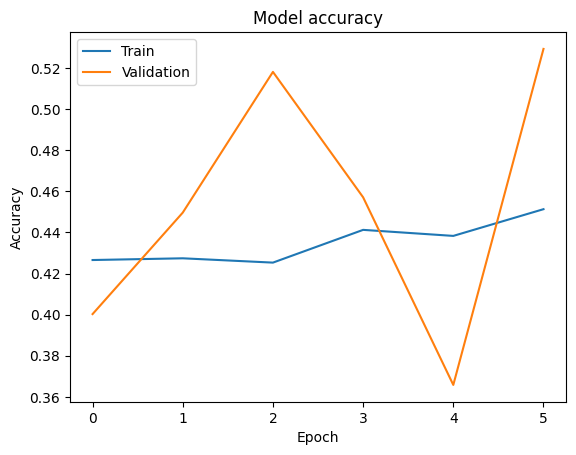

In [17]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluation

#### Compute unbiased estimators of performance using the test set

In [18]:
model.evaluate(test_set)

4/4 [==============================] - 29s 7s/step - loss: 6.2927 - categorical_accuracy: 0.5672 - precision: 0.5672 - recall: 0.5672


[6.2926812171936035,
 0.5672268867492676,
 0.5672268867492676,
 0.5672268867492676]

#### Make a prediction based on a random image from the training set

Using image at position: 19439
1/1 [==============================] - 5s 5s/step
Probability of being MIDDLE is: 99
Probability of being OLD is: 0
Probability of being YOUNG is: 0


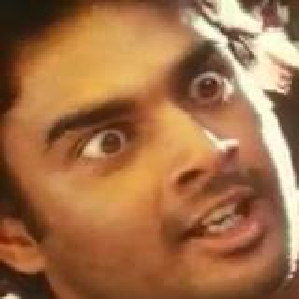

In [19]:
random_id = random.randint(0, raw_df.shape[0])
print('Using image at position:', random_id)
random_row = raw_df.loc[random_id]

path = os.path.join('Data', random_row.ID)
image = load_img(path, target_size=(299, 299))

image_array = np.expand_dims(img_to_array(image), axis=0)
class_probabilities = model.predict(image_array)

for index, probability in enumerate(class_probabilities[0]):
    print(f'Probability of being {classes[index]} is: {int(100 * probability)}')

image

#### Create confusion matrix

4/4 [==============================] - 27s 6s/step


Text(0.5, 36.72222222222221, 'Predicted Labels')

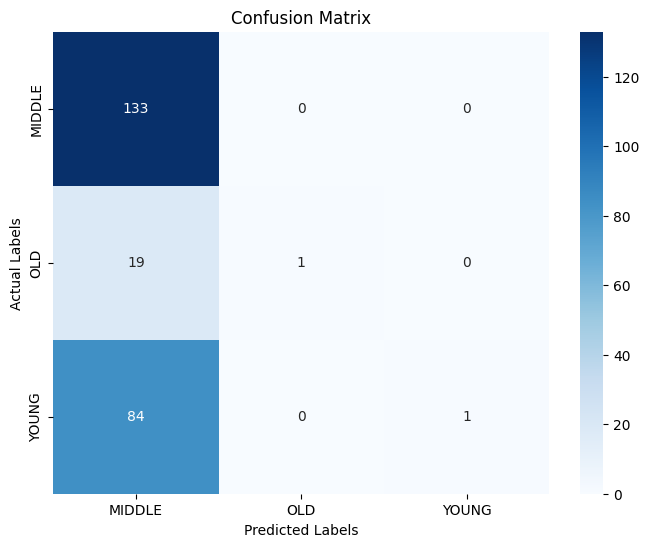

In [20]:
# Generating array of real labels.
y = []
for images, label_batch in test_set:
    y.extend(np.argmax(label_batch, axis=1))

# Generating array of predicted labels.
predictions = model.predict(test_set)
y_hat = np.argmax(predictions, axis=1)

# Create the confusion matrix.
cm = confusion_matrix(y, y_hat)

# Plot the confusion matrix.
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes.values(), yticklabels=classes.values())
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')